In [2]:
# Import the necassry packages
import gplugins.modes as gm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import meep as mp
import gdsfactory as gf
from ubcpdk import PDK, cells
from functools import partial
PDK.activate()
import sax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from simphony.libraries import siepic
from gplugins.devsim import get_simulation_xsection
from gplugins.devsim.get_simulation_xsection import k_to_alpha, clear_devsim_cache
import pyvista as pv
import os

# Design of PN junction

Loading a straing pn junciton component from gdsfactory 

The aim is to do full TCAD simulation to get the Vpi

## Step 1: Import PN junction straight waveguide form GDSFactory

In [3]:
import gdsfactory as gf
from gdsfactory.generic_tech import LAYER, LAYER_STACK
from gdsfactory.technology import LayerLevel, LayerStack

# We choose a representative subdomain of the component
waveguide = gf.Component()
waveguide.add_ref(
    gf.functions.trim(
        component=gf.components.straight_pn(length=10, taper=None).copy(),
        domain=[[3, -4], [3, 4], [5, 4], [5, -4]],
    )
)

waveguide.plot()

scene = waveguide.to_3d()
scene.show()

ValueError: 'pn' not in ['cross_section', 'heater_metal', 'metal_routing', 'strip', 'strip_bbox', 'strip_heater_metal', 'strip_simple', 'strip_unclad']

Run a TCAD simualtion to calculate the carrier desnity of electron (dN) and holes (dP)

In [12]:
active_layer_stack = gf.pdk.get_active_pdk().layer_stack
active_layer_stack.layers


{'substrate': LayerLevel(name=None, layer=WAFER, derived_layer=None, thickness=10.0, thickness_tolerance=None, width_tolerance=None, zmin=-13.0, zmin_tolerance=None, sidewall_angle=0.0, sidewall_angle_tolerance=None, width_to_z=0.0, z_to_bias=None, bias=None, mesh_order=101, material='si', info={}),
 'box': LayerLevel(name=None, layer=WAFER, derived_layer=None, thickness=3.0, thickness_tolerance=None, width_tolerance=None, zmin=-3.0, zmin_tolerance=None, sidewall_angle=0.0, sidewall_angle_tolerance=None, width_to_z=0.0, z_to_bias=None, bias=None, mesh_order=9, material='sio2', info={}),
 'core': LayerLevel(name=None, layer=((WG - DEEP_ETCH) - SHALLOW_ETCH), derived_layer=WG, thickness=0.22, thickness_tolerance=None, width_tolerance=None, zmin=0.0, zmin_tolerance=None, sidewall_angle=10.0, sidewall_angle_tolerance=None, width_to_z=0.5, z_to_bias=None, bias=None, mesh_order=2, material='si', info={}),
 'shallow_etch': LayerLevel(name=None, layer=(SHALLOW_ETCH & WG), derived_layer=SLAB150

Simple step doping. See below for complex doping profile

In [2]:
%%capture  
um = 1e-6
c = get_simulation_xsection.PINWaveguide(
    core_width=0.500 * um,
    core_thickness=0.220 * um,
    slab_thickness=0.090 * um,
)
# Initialize mesh and solver
clear_devsim_cache()
c.ddsolver()
c.save_device('straight_PN.dat')


2025-11-25 20:17:21.123 (5189.345s) [    7BAE26EE4740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


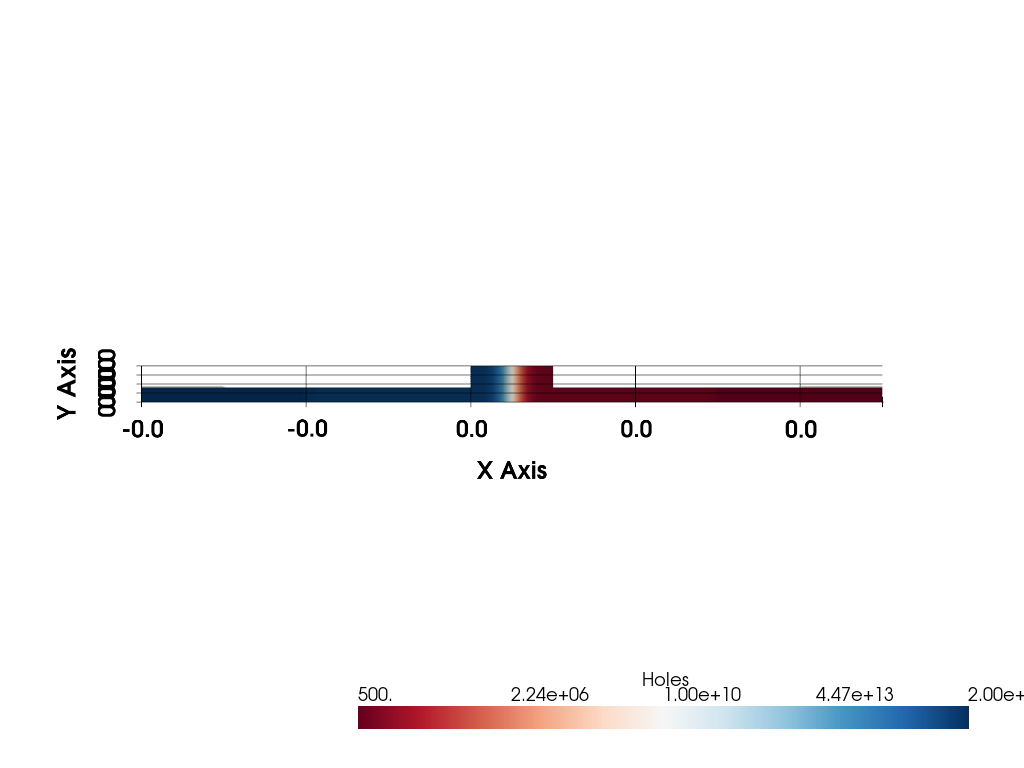

In [51]:
c.plot(scalars="Holes", log_scale=True, jupyter_backend="static")

In [24]:
c.list_fields()

UnstructuredGrid (0x73d215cd24a0)
  N Cells:    8424
  N Points:   4401
  X Bounds:   -2.478e-05, 2.511e-05
  Y Bounds:   9.000e-06, 2.200e-05
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   99

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


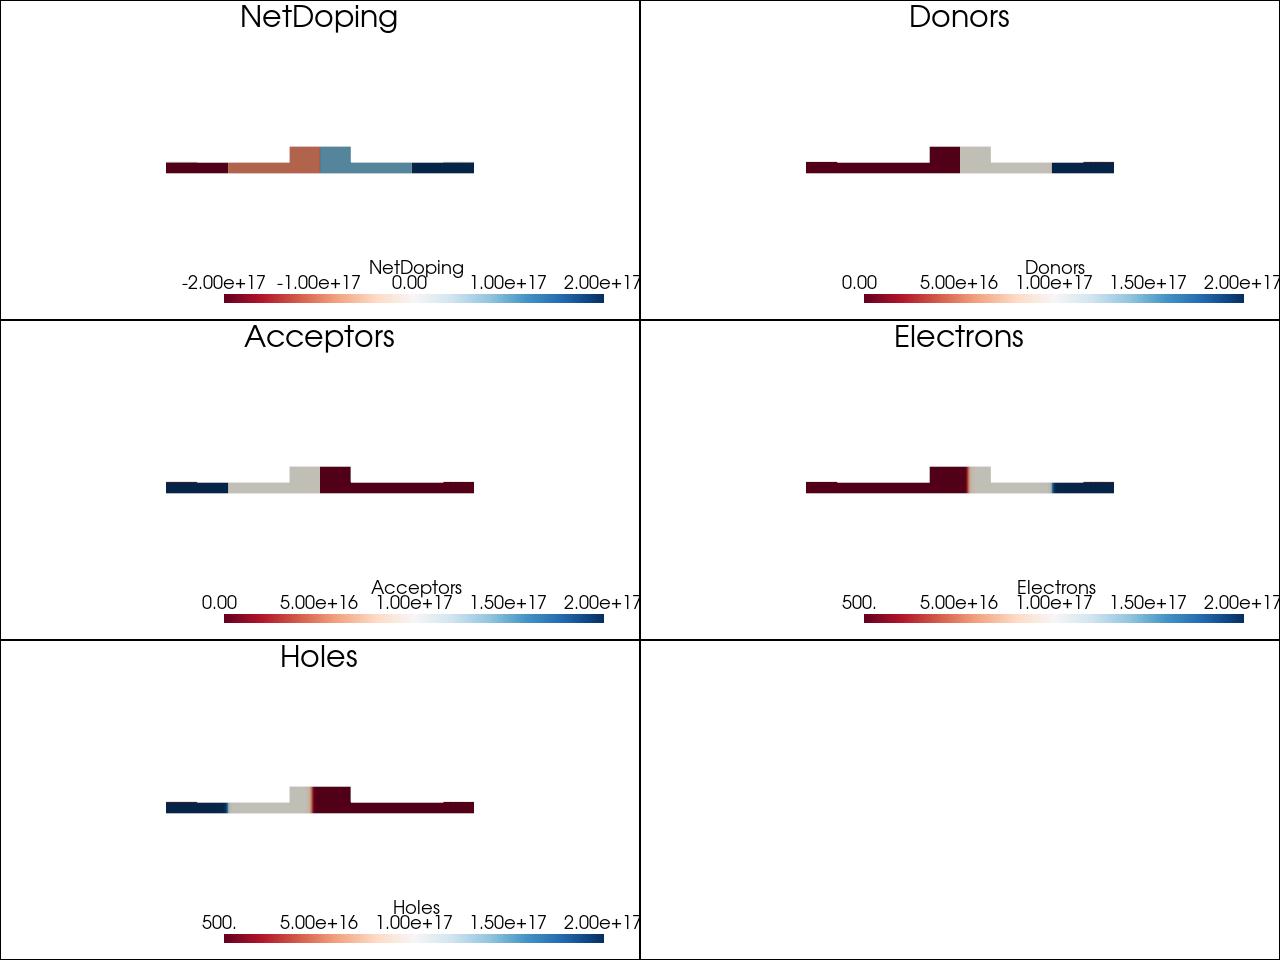

In [22]:
mesh = pv.read('straight_PN.dat')
fields = [
    "NetDoping","Donors","Acceptors",
    "Electrons","Holes"]

p = pv.Plotter(shape=(3,2), notebook='static', window_size=(320*4, 240*4))
# c.plot(scalars="NetDoping", jupyter_backend="static")

idx = 0
for r in range(3):
    for ccol in range(2):
        p.subplot(r, ccol)

        if idx >= len(fields):
            p.add_text("")  # empty cell
            continue

        fname = fields[idx]
        idx += 1

        # if fname not in mesh.array_names:
        #     p.add_text(f"Missing {fname}")
        #     continue

        p.add_mesh(mesh, scalars=fname, cmap="RdBu")
        p.add_text(fname, position="upper_edge", font_size=12)
        _ = p.camera_position = "xy"
        p.add_scalar_bar(title=fname)

p.link_views()
p.show()

Applying voltage and finding the solution

In [29]:
%%capture
# Find a solution with 1V across the junction, ramping by 0.1V steps
c.ramp_voltage(Vfinal=1, Vstep=0.1)
c.save_device('straight_PN_1V.dat')

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


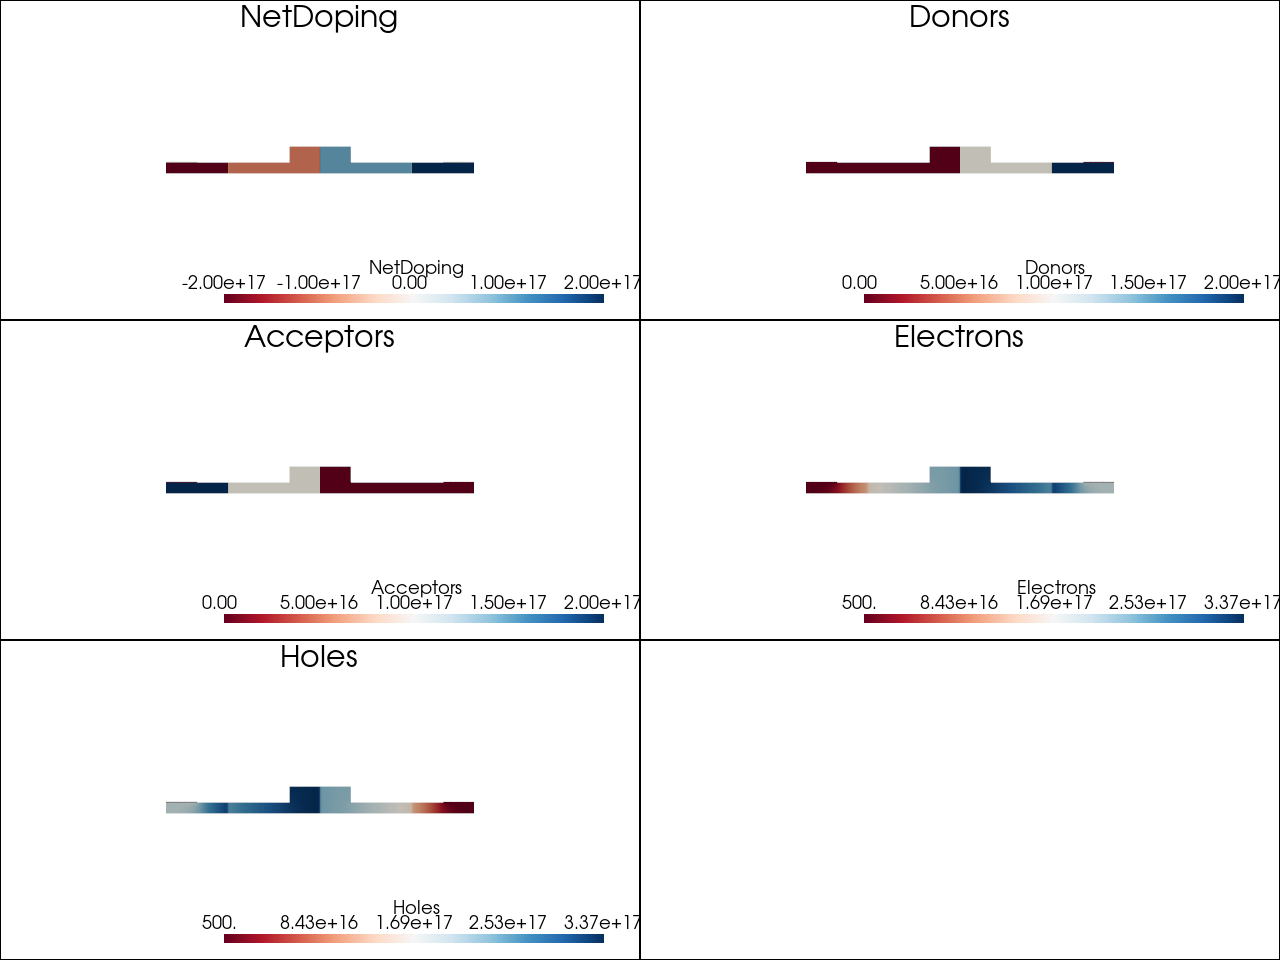

In [30]:
mesh = pv.read('straight_PN_1V.dat')
fields = [
    "NetDoping","Donors","Acceptors",
    "Electrons","Holes"]

p = pv.Plotter(shape=(3,2), notebook='static', window_size=(320*4, 240*4))
# c.plot(scalars="NetDoping", jupyter_backend="static")

idx = 0
for r in range(3):
    for ccol in range(2):
        p.subplot(r, ccol)

        if idx >= len(fields):
            p.add_text("")  # empty cell
            continue

        fname = fields[idx]
        idx += 1

        # if fname not in mesh.array_names:
        #     p.add_text(f"Missing {fname}")
        #     continue

        p.add_mesh(mesh, scalars=fname, cmap="RdBu")
        p.add_text(fname, position="upper_edge", font_size=12)
        _ = p.camera_position = "xy"
        p.add_scalar_bar(title=fname)

p.link_views()
p.show()

Negative bias -1V

In [31]:
%%capture
# Find a solution with 1V across the junction, ramping by 0.1V steps
c.ramp_voltage(Vfinal=-1, Vstep=-0.1)
c.save_device('straight_PN_-1V.dat')

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


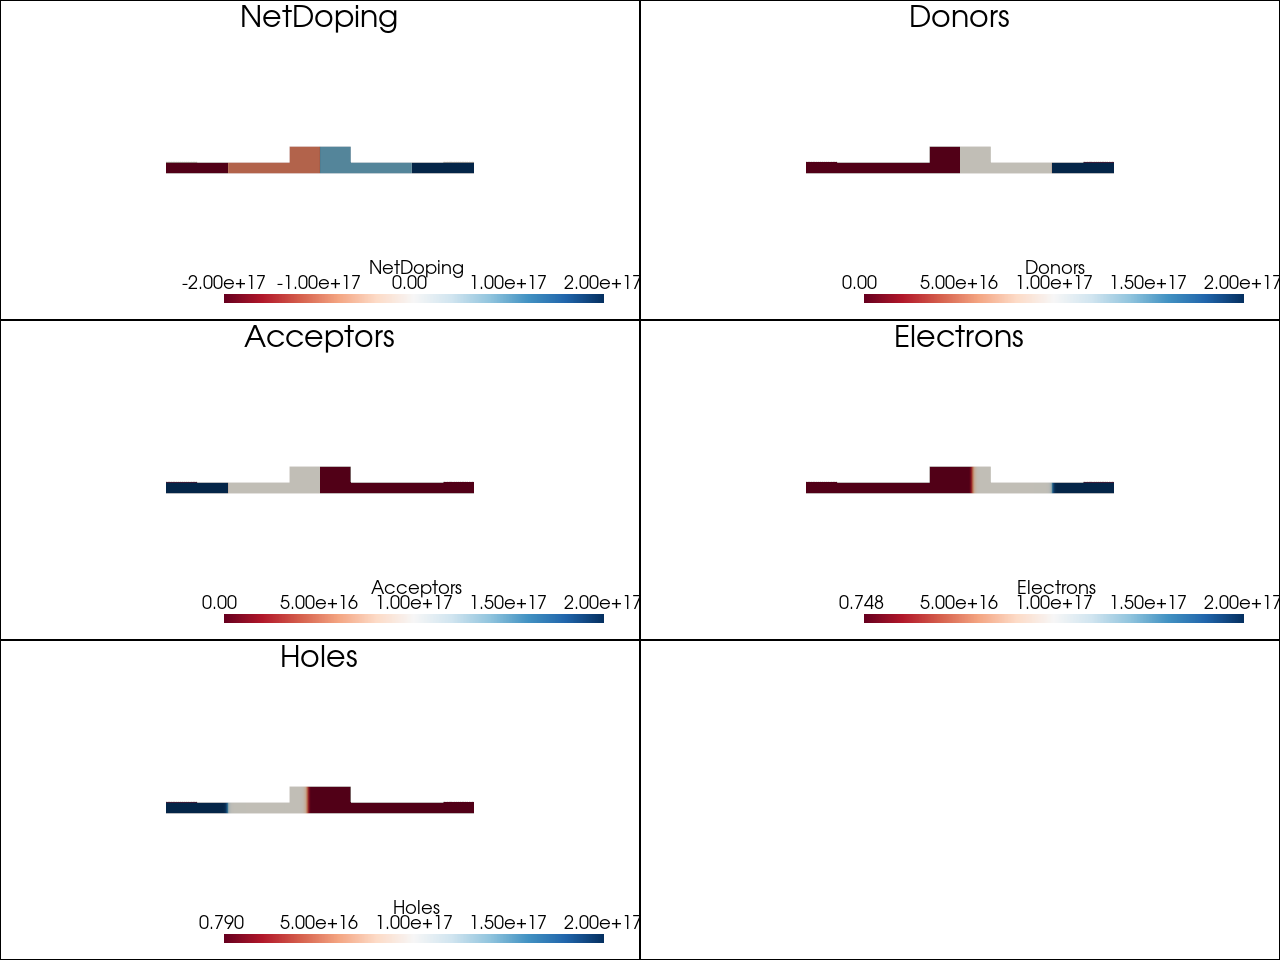

In [32]:
mesh = pv.read('straight_PN_-1V.dat')
fields = [
    "NetDoping","Donors","Acceptors",
    "Electrons","Holes"]

p = pv.Plotter(shape=(3,2), notebook='static', window_size=(320*4, 240*4))
# c.plot(scalars="NetDoping", jupyter_backend="static")

idx = 0
for r in range(3):
    for ccol in range(2):
        p.subplot(r, ccol)

        if idx >= len(fields):
            p.add_text("")  # empty cell
            continue

        fname = fields[idx]
        idx += 1

        # if fname not in mesh.array_names:
        #     p.add_text(f"Missing {fname}")
        #     continue

        p.add_mesh(mesh, scalars=fname, cmap="RdBu")
        p.add_text(fname, position="upper_edge", font_size=12)
        _ = p.camera_position = "xy"
        p.add_scalar_bar(title=fname)

p.link_views()
p.show()

In [ ]:
def plot_carriers(label):
    x  = c.get_field("core", "x")
    Ne = c.get_field("core", "Electrons")
    Ph = c.get_field("core", "Holes")

    idx = np.argsort(x)
    plt.semilogy(x, Ne, label=f"Ne {label}")
    plt.semilogy(x, Ph, label=f"Ph {label}")
    plt.legend()

clear_devsim_cache()
c.ddsolver()
plot_carriers("0V")

clear_devsim_cache()
c.ddsolver()
c.ramp_voltage(Vfinal=-1, Vstep=-0.1)
plot_carriers("-1 V")

clear_devsim_cache()
c.ddsolver()
c.ramp_voltage(Vfinal=1, Vstep=0.1)
plot_carriers("+1 V")


Making waveguide from the devsim device with perturebd index and calculaitng the effective index. Using tidy3d for the mode calcaultions

In [ ]:
%%capture

voltages = [0, -0.2, -0.4, -0.6, -0.8, -1,-1.5, -2,-2.5, -3]#-0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4]
ramp_step = -0.1 

n_dist = {}
neffs   = {}

clear_devsim_cache()
c.ddsolver()     # fresh, clean equilibrium state
cached = "/home/ramprakash/.gdsfactory/modes/Waveguide_*.npz"
if os.path.exists(cached):
    os.remove(cached)
current_bias = 0.0   # solved at 0 V


for ind, voltage in enumerate(voltages):
    clear_devsim_cache()
    c.ddsolver()
    c.ramp_voltage(Vfinal=voltage, Vstep=ramp_step)
    waveguide = c.make_waveguide(wavelength=1.55, perturb=True, grid_resolution=20)
    n_dist[voltage] = waveguide.index.values
    neffs[voltage] = waveguide.n_eff[0]

# for V in voltages:
#     # Skip ramp if already at this voltage
#     if V != current_bias:
#         # choose step direction automatically
#         step = ramp_step if V < current_bias else abs(ramp_step)
#         # ramp from current bias → new voltage
#         c.ramp_voltage(Vfinal=V, Vstep=step, Vinit=current_bias)

#     current_bias = V
    
#     # build perturbed optical waveguide - Smaller res for faster run
#     wg = c.make_waveguide(wavelength=1.55, perturb=True)

#     n_dist[V] = wg.index.values
#     # neffs[V] = wg.n_eff[0]
#     print(f"Voltage value: {V}")


In [31]:
%%capture
clear_devsim_cache()
c.ddsolver()     # fresh, clean equilibrium state
c.ramp_voltage(Vfinal=-0.5, Vstep=-0.1)

In [60]:
%%capture
voltages = [0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -5, -6, -7, -8, -9, -10]
ramp_rate = -0.1

n_dist = {}
neffs = {}
clear_devsim_cache()
um = 1e-6

dev = get_simulation_xsection.PINWaveguide(
    core_width=0.500 * um,
    core_thickness=0.220 * um,
    slab_thickness=0.090 * um,
)
dev.ddsolver()     # fresh, clean equilibrium state
for ind, voltage in enumerate(voltages):
    Vinit = 0 if ind == 0 else voltages[ind - 1]
    dev.ramp_voltage(Vfinal=voltage, Vstep=ramp_rate, Vinit=Vinit)
    waveguide = dev.make_waveguide(wavelength=1.55,grid_resolution=20)
    n_dist[voltage] = waveguide.index.values
    neffs[voltage] = waveguide.n_eff[0]

np.complex128(2.5932203425309455+3.8757826065200905e-05j)

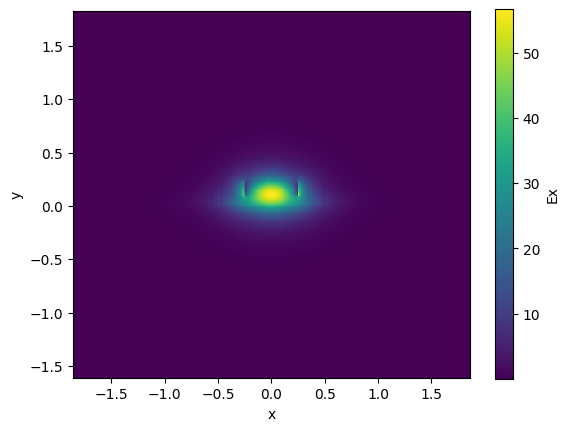

In [42]:
import gplugins.tidy3d as td
wg_td = td.modes.Waveguide(wavelength=1.55,
                core_width=0.5,
                core_thickness=0.22,
                slab_thickness=0.090,
                grid_resolution=50,
                core_material='si',
                clad_material='sio2',
                cache_path=None,
                overwrite=True)
wg_td.plot_field('Ex')
wg_td.n_eff[0]

(0.0, 0.5)

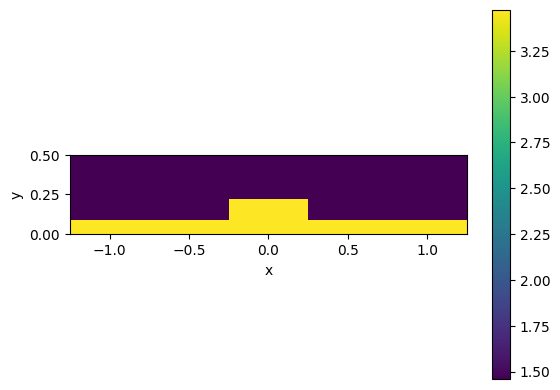

In [16]:
ax = waveguide.plot_index()
ax.axes.set_ylim([0,0.5])

In [3]:
neffs = {0: np.complex128(2.579233149832461+4.2558454254802517e-05j),
 -0.5: np.complex128(2.579248605051533+4.20043472854569e-05j),
 -1: np.complex128(2.5792605310824923+4.1578101252069765e-05j),
 -1.5: np.complex128(2.5792684479189205+4.1298845722944675e-05j),
 -2: np.complex128(2.5792768911186554+4.100265496131908e-05j),
 -2.5: np.complex128(2.579284107736812+4.0752849952389265e-05j),
 -3: np.complex128(2.5719153080505834+4.2195904369172816e-05j),
 -3.5: np.complex128(2.5792960309736594+4.033633789155556e-05j),
 -4: np.complex128(2.57930195707953+4.012628342291738e-05j),
 -5: np.complex128(2.5793103370214245+3.9827958190374006e-05j),
 -6: np.complex128(2.5793178726112416+3.956270654250005e-05j),
 -7: np.complex128(2.579323275257858+3.935982457145146e-05j),
 -8: np.complex128(2.5719524331528962+4.084224984011639e-05j),
 -9: np.complex128(2.5793333855608185+3.901735265199731e-05j),
 -10: np.complex128(2.5793378293861204+3.888440364347489e-05j)}

neffs

{0: np.complex128(2.579233149832461+4.2558454254802517e-05j),
 -0.5: np.complex128(2.579248605051533+4.20043472854569e-05j),
 -1: np.complex128(2.5792605310824923+4.1578101252069765e-05j),
 -1.5: np.complex128(2.5792684479189205+4.1298845722944675e-05j),
 -2: np.complex128(2.5792768911186554+4.100265496131908e-05j),
 -2.5: np.complex128(2.579284107736812+4.0752849952389265e-05j),
 -3: np.complex128(2.5719153080505834+4.2195904369172816e-05j),
 -3.5: np.complex128(2.5792960309736594+4.033633789155556e-05j),
 -4: np.complex128(2.57930195707953+4.012628342291738e-05j),
 -5: np.complex128(2.5793103370214245+3.9827958190374006e-05j),
 -6: np.complex128(2.5793178726112416+3.956270654250005e-05j),
 -7: np.complex128(2.579323275257858+3.935982457145146e-05j),
 -8: np.complex128(2.5719524331528962+4.084224984011639e-05j),
 -9: np.complex128(2.5793333855608185+3.901735265199731e-05j),
 -10: np.complex128(2.5793378293861204+3.888440364347489e-05j)}

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$\\Delta n_{eff}$')

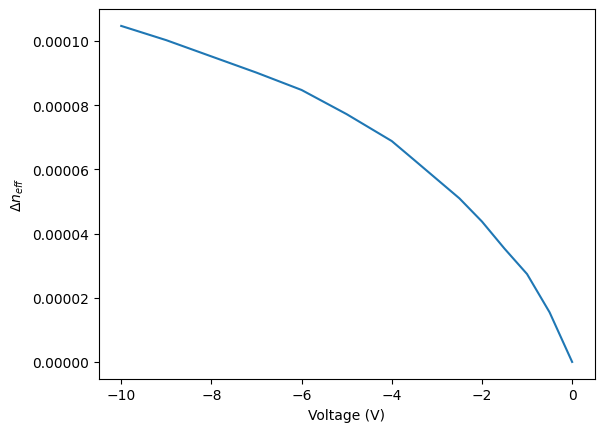

In [5]:
voltage_list = sorted(neffs.items())
x, y = zip(*voltage_list)
y_array = np.array(y)
x_array = np.array(x)
dneff = y-neffs[0]
plt.plot(x, dneff)

plt.xlabel("Voltage (V)")
plt.ylabel(r"$\Delta n_{eff}$")

Text(0, 0.5, '$\\alpha (dB/cm)$')

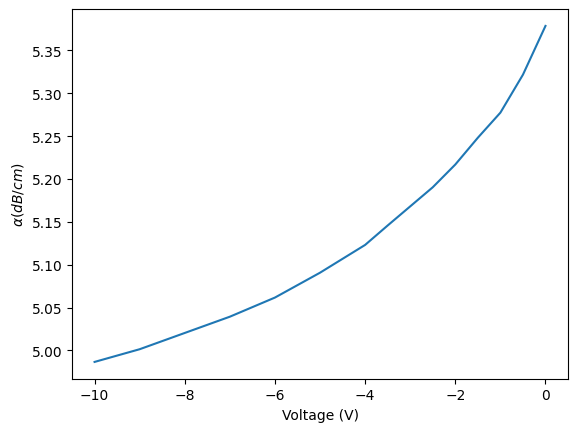

In [6]:
voltage_list = sorted(neffs.items())
x, y = zip(*voltage_list)

plt.plot(x, 10 * np.log10(k_to_alpha(np.imag(y), wavelength=1.55)))

plt.xlabel("Voltage (V)")
plt.ylabel(r"$\alpha (dB/cm)$")

Text(0.5, 1.0, 'Imaginary part of refractive index (k)')

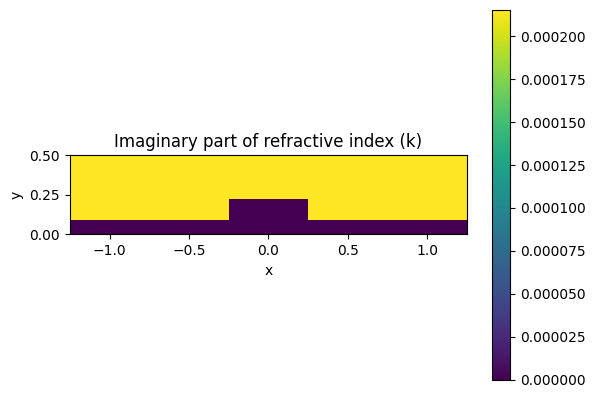

In [35]:
c_undoped = c.make_waveguide(wavelength=1.55, perturb=False, precision="double", grid_resolution=30)
# c_undoped.compute_modes()
n_undoped = c_undoped.index.values
ax2 =  c_undoped.index.imag.plot()
ax2.axes.set_aspect("equal")
ax2.axes.set_ylim([0, 0.5])
plt.title("Imaginary part of refractive index (k)")

/tmp/ipykernel_2589823/3365713181.py:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(np.imag(n_dist[voltage]- n_undoped))),


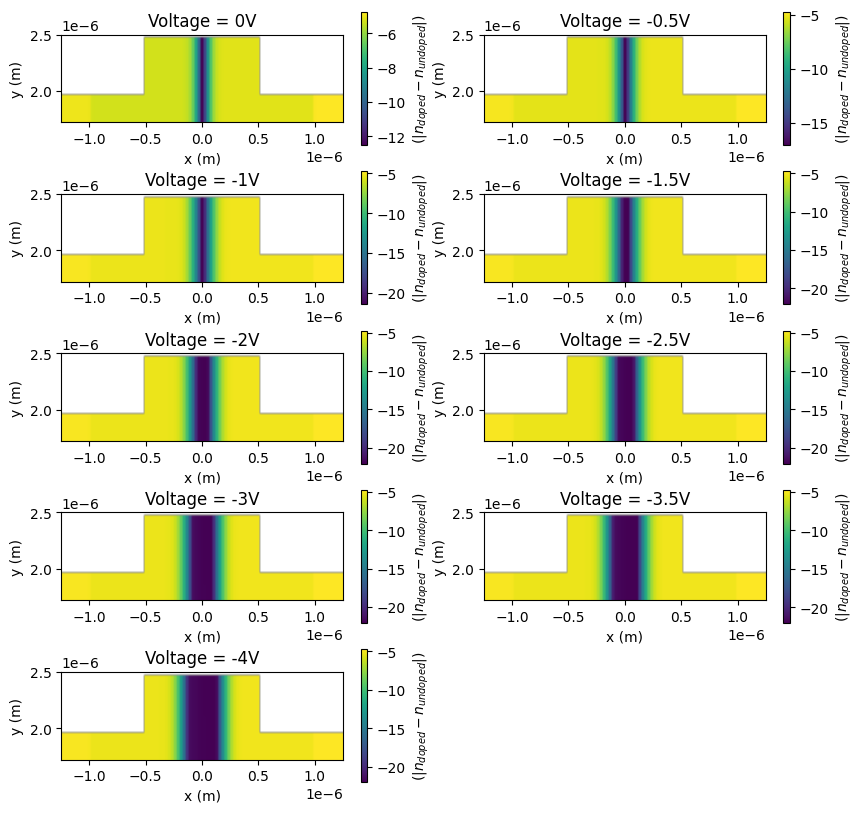

In [36]:
plt.figure(figsize=(10,10))
for ind, voltage in enumerate(voltages):
    plt.subplot(5,2,ind+1)
    plt.imshow(
        np.log10(np.abs(np.imag(n_dist[voltage]- n_undoped))),
        origin="lower",
        extent=[
            -c.xmargin - c.ppp_offset - c.core_width / 2,
            c.xmargin + c.npp_offset + c.core_width / 2,
            0,
            c.clad_thickness + c.box_thickness + c.core_thickness,
        ],
    )
    plt.colorbar(label="$(|n_{doped} - n_{undoped}|)$")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.ylim(1.72e-6, 2.5e-6)
    plt.title(f"Voltage = {voltage}V")

Calacute the Vpi then have to build the compact model for the same. Finally use this in the ring resonator model

Phase change can be claculated form dn. So using this Vpi is calcaulted

Not too good - But okay for a proof of concept design

Text(0, 0.5, '$\\Delta\\phi (\\pi/cm)$')

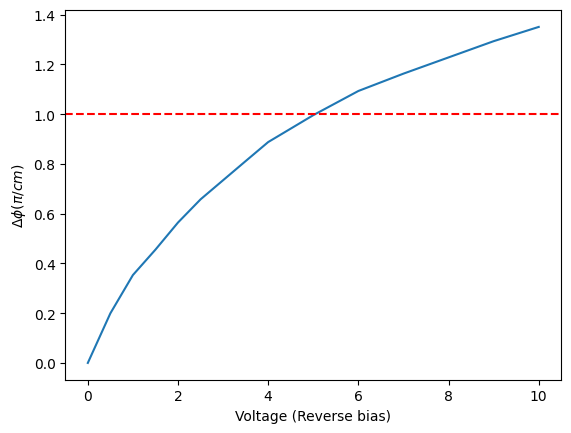

In [8]:
lamda = 1.55e-6
dphi = (2*np.pi/lamda)*(dneff*1e-2)/np.pi
plt.plot(-x_array,dphi)
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Voltage (Reverse bias)')
plt.ylabel(r"$\Delta\phi (\pi/cm)$")
